In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('usd_curve.csv')
times = data['t'].values
df = data['df'].values

class HullWhite():
    def __init__(self, a, sigma, timesteps, x0=0):
        self.a = a
        self.sigma = sigma
        self.timesteps = timesteps
        self.x0 = x0
        
    def hw_exp(self, x, t1, t2):
        return x * np.exp(-self.a * (t2 - t1))
    
    def hw_var(self, t1, t2):
        return self.sigma ** 2 * (1 - np.exp(-2 * self.a * (t2 - t1))) / (2 * self.a)

    def MC(self, sims):
        x = np.zeros((sims, self.timesteps))
        for i in range(sims):
            x[i,0] = self.x0
            for j in range(1, self.timesteps):
                Z1 = np.random.normal(0,1)
                x[i,j] = self.hw_exp(x[i,j-1], j-1, j) + Z1 * (self.hw_var(j-1,j) ** 0.5)
        return x     
    


In [3]:
class DiscountFactors():
    def __init__(self, a, sigma):
        self.a = a
        self.sigma = sigma
        
    def q_t(self, t, T):
         return (1 - np.exp(-self.a * (T - t))) / self.a

    def cov(self, t_i, t_j):
        return self.sigma ** 2 * (np.exp(-self.a * abs(t_j - t_i)) - np.exp(-self.a * (t_j + t_i))) / (2 * self.a)
 
    def hw_phi(self, q_val, cov_val):
        return sum(q * cov for q, cov in zip(q_values, cov_values))

    def hw_gamma(self, tn):
        return 0.5 * self.cov(tn, tn)

    def interpolated_df(self, t, time, df):
        return np.interp(t, time, df)
    
    def df(self, t_n, T, x_tn, q_val, cov_val):
        B_tn = self.interpolated_df(t_n, times, df)
        B_T = self.interpolated_df(T, times, df)
        if t_n == 0:
            discount_factor = B_T / B_tn 
        else:
            phi = self.hw_phi(q_val, cov_val)
            gamma = self.hw_gamma(t_n)
            q_tn = self.q_t(t_n, T)
            discount_factor = (B_T / B_tn) * np.exp(-(x_tn + phi) * q_tn - gamma * (q_tn ** 2))
        return discount_factor
        

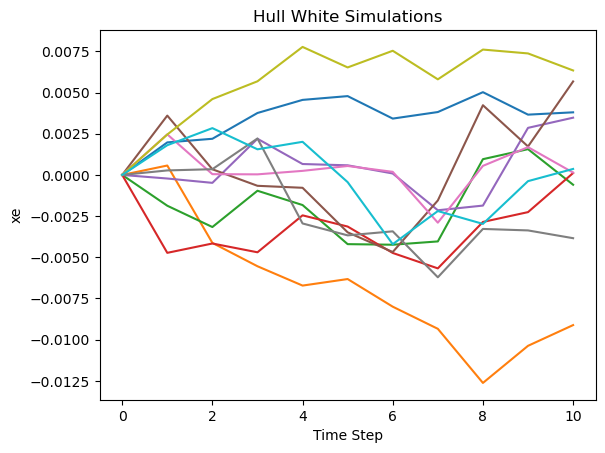

In [4]:
# Testing Hull White

a = 0.1
x0 = 0
sigma = 0.002

timesteps = 10

# MC Parameters
sims = 10
T = 10
dt = T / timesteps  
hw_timesteps = int(T / dt) + 1

hw = HullWhite(a, sigma, hw_timesteps, x0)
simulated_paths = hw.MC(sims)
hwdf = DiscountFactors(a, sigma)

#print (simulated_paths)
#print (hw_timesteps)
#print (dt)

for i in range(sims):
    plt.plot(simulated_paths[i])
plt.xlabel('Time Step')
plt.ylabel('xe')
plt.title('Hull White Simulations')
plt.show()

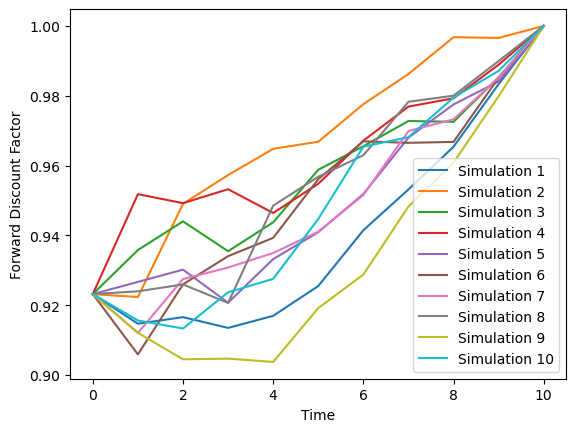

In [6]:
q_values = []
cov_values = []
for x in range(timesteps + 1):
    q_val1 = hwdf.q_t(x, x + 1)
    cov1 = hwdf.cov(x, timesteps + 1)
    q_values.append(q_val1)
    cov_values.append(cov1)

result = sum(q * cov for q, cov in zip(q_values, cov_values))

for i in range(sims):
    x_tn_values = simulated_paths[i]

    for t_n in range(hw_timesteps):
        t = t_n * dt  
        T = T         
        q_val = hwdf.q_t(t, T)
        cov_val = hwdf.cov(t, T)
        discount_factor = hwdf.df(t, T, x_tn_values[t_n], q_val, cov_val)  
        
discount_factors = np.zeros((sims, hw_timesteps))        

       
for i in range(sims):
    x_tn_values = simulated_paths[i]
    for t_n in range(hw_timesteps):
        t = t_n * dt  
        T = T      
        q_val = hwdf.q_t(t, T)
        cov_val = hwdf.cov(t, T)
        discount_factors[i, t_n] = hwdf.df(t, T, x_tn_values[t_n], q_val, cov_val)

#print(discount_factors)        
       
for i in range(sims):
    plt.plot(np.arange(hw_timesteps) * dt, discount_factors[i], label=f'Simulation {i+1}')

plt.xlabel('Time')
plt.ylabel('Forward Discount Factor')
plt.legend()
plt.show()

In [7]:
#need to rewrite this so it is consistent with LMM, when that is ready

def swap_pricer(Notional, fixed_Rate, Maturity, T_n, sims, hwdf, times, df):
    
    fixed_cash_flows = [fixed_Rate] * Maturity
    present_values = np.zeros((sims, len(fixed_cash_flows)))

    for i in range(sims):
        for t in range(T_n, Maturity):  # Start t from T_n
            t_1 = t + 1
            T = Maturity
           
            x_tn_values = np.zeros(Maturity)
            x_tn_values[T_n] = hw.x0  # Initialize x_tn_values for each T_n

            # Calculate x_tn_values for the entire path
            for j in range(T_n + 1, Maturity):
                Z1 = np.random.normal(0, 1)
                x_tn_values[j] = hw.hw_exp(x_tn_values[j - 1], j - 1, j) + Z1 * (hw.hw_var(j - 1, j) ** 0.5)
           
            frw_discount_factor = hwdf.df(t, t_1, x_tn_values[t], q_val, cov_val)
           
            # Check if frw_discount_factor is valid before taking the logarithm
            if frw_discount_factor > 0:
                Forward_rate = -np.log(frw_discount_factor) / (t_1 - t)
            else:
                Forward_rate = 0  # Set to a default value or handle this case as needed
           
            df_tn = hwdf.df(T_n, t_1, x_tn_values[T_n], q_val, cov_val)

            fixed_present_value = (fixed_cash_flows[t] * Notional) * df_tn
            floating_present_value = (Forward_rate * Notional) * df_tn

            present_values[i, t] = (floating_present_value - fixed_present_value)
           
            df_tn = round(df_tn, 3)
            Forward_rate = round(Forward_rate, 3)
            frw_discount_factor = round(frw_discount_factor, 3)
           
            # Print the desired output
            print(f"Sim {i+1}, t_n = {T_n}, t = {t}, t_1 = {t_1}, T = {mat}: df = {df_tn}, Fwd = {Forward_rate},  frw_df = {frw_discount_factor}")

    swap_values = present_values.sum(axis=1)

    return swap_values

mat = 5

for T_n in range(mat):
    swap_values = swap_pricer(10000, 0.001, mat, T_n, sims, hwdf, times, df)
    for sim in range(sims):
        print(f"Simulation {sim+1}, T_n = {T_n}: Total Swap Value = {swap_values[sim]}")

Notional = 10000

Sim 1, t_n = 0, t = 0, t_1 = 1, T = 5: df = 0.997, Fwd = 0.003,  frw_df = 0.997
Sim 1, t_n = 0, t = 1, t_1 = 2, T = 5: df = 0.995, Fwd = 0.002,  frw_df = 0.998
Sim 1, t_n = 0, t = 2, t_1 = 3, T = 5: df = 0.991, Fwd = -0.001,  frw_df = 1.001
Sim 1, t_n = 0, t = 3, t_1 = 4, T = 5: df = 0.986, Fwd = 0.005,  frw_df = 0.995
Sim 1, t_n = 0, t = 4, t_1 = 5, T = 5: df = 0.979, Fwd = 0.005,  frw_df = 0.995
Sim 2, t_n = 0, t = 0, t_1 = 1, T = 5: df = 0.997, Fwd = 0.003,  frw_df = 0.997
Sim 2, t_n = 0, t = 1, t_1 = 2, T = 5: df = 0.995, Fwd = 0.005,  frw_df = 0.995
Sim 2, t_n = 0, t = 2, t_1 = 3, T = 5: df = 0.991, Fwd = 0.005,  frw_df = 0.995
Sim 2, t_n = 0, t = 3, t_1 = 4, T = 5: df = 0.986, Fwd = 0.005,  frw_df = 0.995
Sim 2, t_n = 0, t = 4, t_1 = 5, T = 5: df = 0.979, Fwd = 0.008,  frw_df = 0.992
Sim 3, t_n = 0, t = 0, t_1 = 1, T = 5: df = 0.997, Fwd = 0.003,  frw_df = 0.997
Sim 3, t_n = 0, t = 1, t_1 = 2, T = 5: df = 0.995, Fwd = 0.002,  frw_df = 0.998
Sim 3, t_n = 0, t = 2, t_1 = 3, T = 5: 

In [30]:


    def calculate_present_value_fixed_leg(self):
        # Calculate the present value of the fixed leg
        cash_flows = [(self.fixed_rate / self.freq) * self.notional * self._discount_factor(t)
                      for t in np.arange(1 / self.freq, self.maturity + 1 / self.freq, 1 / self.freq)]
        return sum(cash_flows)

    def calculate_present_value_floating_leg(self):
        # Calculate the present value of the floating leg
        cash_flows = [(self._floating_rate(t) / self.freq) * self.notional * self._discount_factor(t)
                      for t in np.arange(1 / self.freq, self.maturity + 1 / self.freq, 1 / self.freq)]
        return sum(cash_flows)

    def calculate_swap_value(self):
        # Calculate the swap value
        fixed_leg_pv = self.calculate_present_value_fixed_leg()
        floating_leg_pv = self.calculate_present_value_floating_leg()
        return fixed_leg_pv - floating_leg_pv

def swap_pricer(notional, fixed_rate, forward_curve, maturity, d_f):
    cashflow_fixed = sum([(fixed_rate * notional * d_f(t)) for t in np.arange(0,maturity,1)])
    cashflow_float = sum([(forward * notional * d_f()) for t in np.arange(0, maturity,1)])
    return cashflow_fixed - cashflow_float 
    
    
# Define simple yield curves for discounting and forecasting (for example purposes)
def discount_curve(t):
    return 0.02  # 2% constant yield for discounting

def forecast_curve(t):
    return 0.015  # 1.5% constant yield for forecasting floating rates

# Define swap parameters
notional = 1000000
fixed_rate = 0.02
maturity = 5
freq = 1

# Initialize the pricer and calculate the swap value
pricer = InterestRateSwapPricer(notional, fixed_rate, maturity, freq, discount_curve, forecast_curve)
swap_value = pricer.calculate_swap_value()
print(f"Swap Value: {swap_value}")


Swap Value: 23553.53205232961


In [31]:
import numpy as np

class InterestRateSwapPricer:
    def __init__(self, notional, fixed_rate, maturity, freq, discount_curve, forecast_curve):
        self.notional = notional
        self.fixed_rate = fixed_rate
        self.maturity = maturity
        self.freq = freq
        self.discount_curve = discount_curve
        self.forecast_curve = forecast_curve

    def _discount_factor(self, t):
        # Calculate the discount factor for time t using the provided discount curve
        return np.exp(-self.discount_curve(t) * t)

    def _floating_rate(self, t):
        # Forecast the floating rate for time t using the provided forecast curve
        return self.forecast_curve(t)

    def calculate_present_value_fixed_leg(self):
        # Calculate the present value of the fixed leg
        cash_flows = [(self.fixed_rate / self.freq) * self.notional * self._discount_factor(t)
                      for t in np.arange(1 / self.freq, self.maturity + 1 / self.freq, 1 / self.freq)]
        return sum(cash_flows)

    def calculate_present_value_floating_leg(self):
        # Calculate the present value of the floating leg
        cash_flows = [(self._floating_rate(t) / self.freq) * self.notional * self._discount_factor(t)
                      for t in np.arange(1 / self.freq, self.maturity + 1 / self.freq, 1 / self.freq)]
        return sum(cash_flows)

    def calculate_swap_value(self):
        # Calculate the swap value
        fixed_leg_pv = self.calculate_present_value_fixed_leg()
        floating_leg_pv = self.calculate_present_value_floating_leg()
        return fixed_leg_pv - floating_leg_pv


# Define simple yield curves for discounting and forecasting (for example purposes)
def discount_curve(t):
    return 0.02  # 2% constant yield for discounting

def forecast_curve(t):
    return 0.015  # 1.5% constant yield for forecasting floating rates

# Define swap parameters
notional = 1000000
fixed_rate = 0.02
maturity = 5
freq = 1

# Initialize the pricer and calculate the swap value
pricer = InterestRateSwapPricer(notional, fixed_rate, maturity, freq, discount_curve, forecast_curve)
swap_value = pricer.calculate_swap_value()
print(f"Swap Value: {swap_value}")


Swap Value: 23553.53205232961


In [12]:
f = (4,5,6,7,8)

f[3] = 10

print(f)

cashflow = sum([f[i] * 0.5 for i in range(len(f))])
f = [f[i] * 0.5 for i in range(len(f))]

print(cashflow)
print(f)

f[3] = 1

print(f)


TypeError: 'tuple' object does not support item assignment